In [225]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/david/Documents/Projects/causal-inference-forest-fire-ignition/notebooks/../src/causal_graph.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  ('forest_coverage', 'streuschicht'),


In [226]:
import sys
sys.path.append("../")

In [256]:
import pandas as pd
import geopandas as gpd
from dowhy import gcm, CausalModel
from dowhy.utils import plot
import networkx as nx
import matplotlib.pyplot as plt

from src.preprocessing_functions import (classify_aspect,
                                    classify_canopy_cover,
                                    forest_type_mapping,
                                    apply_encoding, 
                                    classify_population, 
                                    classify_elevation,
                                    classify_slope,
                                    map_to_binary)
from src.causal_graph import create_causal_graph_no_weather

In [228]:
# read in training data
path_to_observational_data = r"../data/data_all_factors/training_data.shp"
obs_data_raw = gpd.read_file(path_to_observational_data)
obs_data_raw.date = pd.to_datetime(obs_data_raw.date)

In [229]:
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """data preprocessing - mainly classification"""

    data.rename(columns={"farmyard_d": "farmyard_density", 
                         "hiking_ds": "hikingtrail_density", 
                         "forest_ds": "forestroad_density", 
                         "rail_dens": "railway_density", 
                         "foresttype": "forest_type", 
                         "pop_dens": "population_density", 
                         "canopy_cov": "canopy_coverage"}, inplace=True)

    data.dropna(subset=("forest_type", "canopy_coverage"), inplace=True)
    processed_data_dict = {

        "date": data["date"],
        "loc_uncertainty": data["Pufferradi"],

        "exposition": data["aspect"].apply(classify_aspect),
        "elevation": data["elevation"].apply(classify_elevation),
        "slope": data["slope"].apply(classify_slope),

        "farmyard": data["farmyard_density"].apply(map_to_binary),
        "forestroad": data["forestroad_density"].apply(map_to_binary),
        "railway": data["railway_density"].apply(map_to_binary),
        "hikingtrail": data["hikingtrail_density"].apply(map_to_binary),
        "population": data["population_density"].apply(classify_population),

        "forest_type": data['forest_type'].apply(lambda x: apply_encoding(int(x), forest_type_mapping)),
        "forest_coverage": data["canopy_coverage"].apply(classify_canopy_cover),

        "ffmc": data["ffmc"],
        "fire": data["fire"].astype("str")}
    return pd.DataFrame(processed_data_dict)

In [230]:
data_obs_prep = preprocess_data(obs_data_raw)

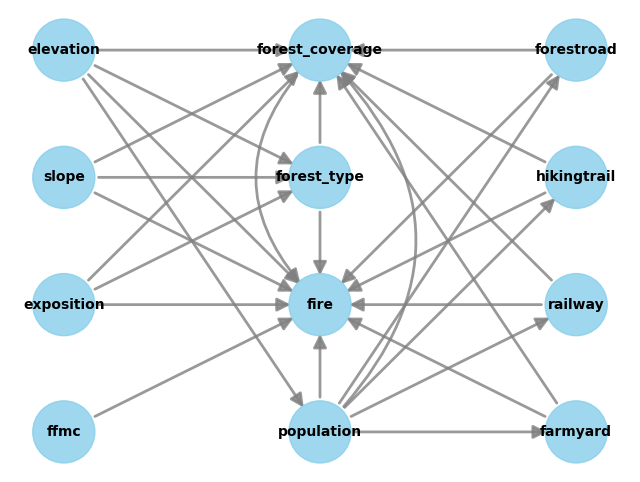

In [239]:
causal_graph = create_causal_graph_no_weather()
model = CausalModel(
    data=data_obs_prep,
    treatment="forest_type",
    outcome="fire",
    graph=causal_graph)
model.view_model()

In [255]:
# create two datasets. One with all data & one dataset with low location uncertainty
fire_samples = data_obs_prep[(data_obs_prep["fire"] == "1")]
fire_samples_low_loc = fire_samples[fire_samples["loc_uncertainty"].astype("int") < 200]
non_fire_samples = data_obs_prep[(data_obs_prep["fire"] == "0")]
non_fire_samples_sampled = non_fire_samples.sample(len(fire_samples_low_loc))
data_obs_prep_low_unc = pd.concat([fire_samples_low_loc, non_fire_samples_sampled])

### Create the causal model

In [234]:
def plot_digraph(G):
    pos = nx.spring_layout(G) 
    nx.draw(G, pos, with_labels=True, arrows=True)  # Draw nodes and edges with labels and arrows
    edge_labels = nx.get_edge_attributes(G, 'name')  # Get edge names
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)  # Draw edge names
    plt.show()

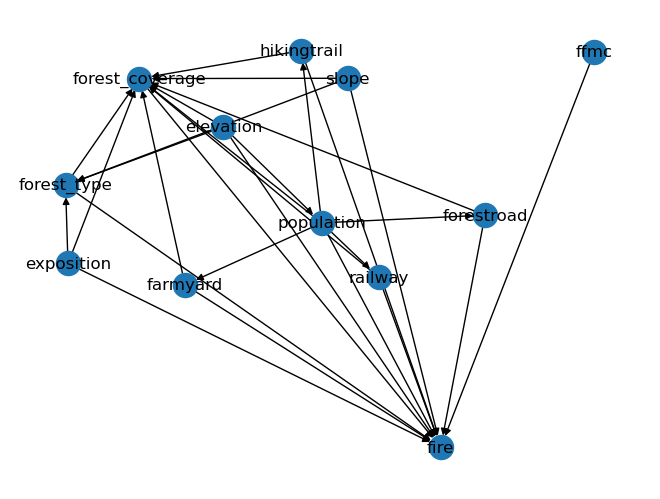

In [235]:
causal_graph = create_causal_graph_no_weather()
causal_model = gcm.ProbabilisticCausalModel(causal_graph)
plot_digraph(causal_graph)

In [160]:
#causal_model.set_causal_mechanism('ffmc', gcm.AdditiveNoiseModel(FFMCModel))
#causal_model.set_causal_mechanism("fire", gcm.ClassifierFCM(gcm.ml.classification.create_random_forest_classifier))

In [161]:
causal_mechanisms_summary = gcm.auto.assign_causal_mechanisms(causal_model, data_obs_prep)

In [162]:
print(causal_mechanisms_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [163]:
gcm.fit(causal_model, data_obs_prep)

Fitting causal mechanism of node ffmc: 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]          


Test permutations of given graph: 100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


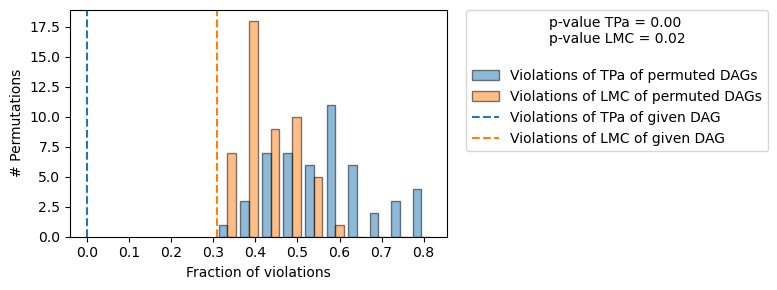

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [164]:
summary_evaluation = gcm.evaluate_causal_model(causal_model, data_obs_prep, compare_mechanism_baselines=True)
print(summary_evaluation)

### Causal Tasks

#### ACE of forest cover, forest type & exposition 
The impact mediated over one of the other factors should be eliminated

In [165]:
forest_cover_classes = ["cc<=20", "20<cc<=40", "40<cc<=60", "60<cc<=80", "cc>80"]
exposition_classes = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
forest_type_classes = ["coniferous non pine", "coniferous with mixed pine", "pine pure", 
                      "coniferous deciduous mixed with pine", "coniferous deciduous mixed non pine", "deciduous pure", "low and no vegetation"]

def construct_ate_dict(exposition_classes, ref_value):
    ate_dict = {"ref_value": ref_value, "ate": {}}  
    for region in exposition_classes:
        ate_dict["ate"][region] = {}
    return ate_dict

def get_ate_with_confidence_for_factor_classes(ate_dict: dict, factor_name: str, causal_model):
    for cl in ate_dict["ate"].keys():
        effect_median, effect_interval = gcm.confidence_intervals(
            gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                causal_model, "fire", 
                                interventions_alternative={factor_name: lambda x: cl},
                                interventions_reference={factor_name: lambda x: ate_dict["ref_value"]}, 
                                num_samples_to_draw=1000))
        ate_dict["ate"][cl]["median"] = effect_median[0]
        ate_dict["ate"][cl]["interval"] = effect_interval[0]
    return ate_dict

def plot_ate_with_confidence(ate_data):
    regions = list(ate_data['ate'].keys())
    ate_values = [ate_data['ate'][region]['median'] for region in regions]
    lower_bounds = [ate_data['ate'][region]['interval'][0] for region in regions]
    upper_bounds = [ate_data['ate'][region]['interval'][1] for region in regions]

    fig, ax = plt.subplots()
    y_pos = np.arange(len(regions))


    ax.errorbar(ate_values, y_pos, xerr=[np.array(ate_values) - np.array(lower_bounds), np.array(upper_bounds) - np.array(ate_values)],
                fmt='o', color='black', capsize=5, markersize=5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(regions)
    ax.axvline(x=0, color='gray', linestyle='--')
    ax.set_xlabel('ATE')
    ax.set_title('Average Treatment Effect (ATE) with Confidence Intervals')
    plt.show()

/home/david/Documents/Projects/causal-inference-forest-fire-ignition/notebooks/../src/causal_graph.py:71: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if human_factor is not "population":


##### ACE of exposition

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


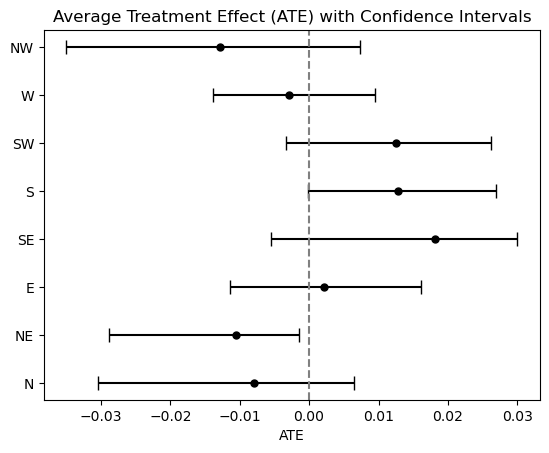

In [166]:
ate_dict_exposition = construct_ate_dict(exposition_classes, "E")

for exp in exposition_classes:

    effect_median, effect_interval = gcm.confidence_intervals(
                gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                    causal_model, "fire", 
                                    interventions_alternative={'exposition': lambda x: exp, 
                                                        'forest_type': lambda x: "pine pure", 
                                                        'forest_coverage': lambda x: "40<cc<=60"},
                                    interventions_reference={'exposition': lambda x: "E", 
                                                    'forest_type': lambda x: "pine pure",
                                                    'forest_coverage': lambda x: "40<cc<=60"},
                                    observed_data=data_obs_prep))
    
    ate_dict_exposition["ate"][exp]["median"] = effect_median[0]
    ate_dict_exposition["ate"][exp]["interval"] = effect_interval[0]

plot_ate_with_confidence(ate_dict_exposition)

##### ACE for forest type

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


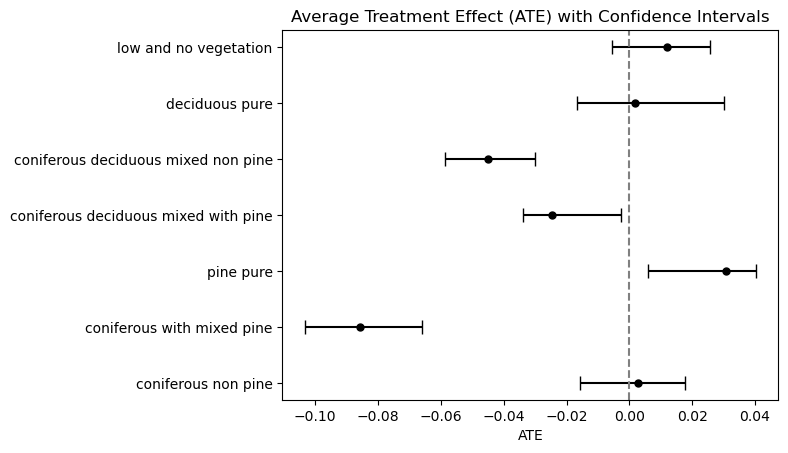

In [167]:
ate_dict_foresttype = construct_ate_dict(forest_type_classes, "coniferous non pine")

for ft in forest_type_classes:

    effect_median, effect_interval = gcm.confidence_intervals(
                gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                    causal_model, "fire", 
                                    interventions_alternative={'forest_type': lambda x: ft, 
                                                        'forest_coverage': lambda x: "40<cc<=60"},
                                    interventions_reference={'forest_type': lambda x: "coniferous non pine", 
                                                    'forest_coverage': lambda x: "40<cc<=60"},
                                    observed_data=data_obs_prep))
    
    ate_dict_foresttype["ate"][ft]["median"] = effect_median[0]
    ate_dict_foresttype["ate"][ft]["interval"] = effect_interval[0]

plot_ate_with_confidence(ate_dict_foresttype)

##### ACE for forest coverage

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]


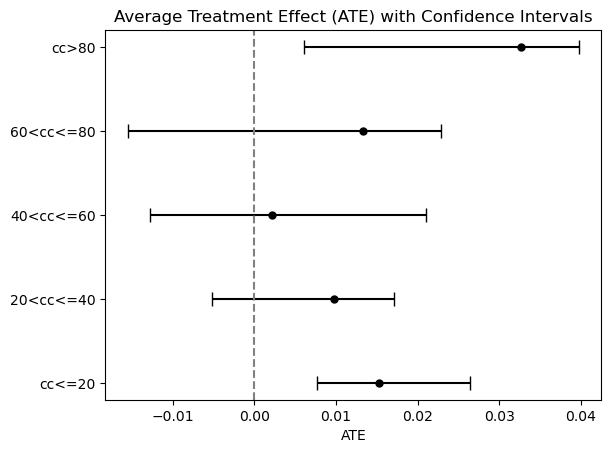

In [168]:
ate_dict_forestcoverage = construct_ate_dict(forest_cover_classes, "40<cc<=60")

for fcc in forest_cover_classes:

    effect_median, effect_interval = gcm.confidence_intervals(
                gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                    causal_model, "fire", 
                                    interventions_alternative={'forest_coverage': lambda x: fcc},
                                    interventions_reference={'forest_coverage': lambda x: "40<cc<=60"},
                                    observed_data=data_obs_prep))
    
    ate_dict_forestcoverage["ate"][fcc]["median"] = effect_median[0]
    ate_dict_forestcoverage["ate"][fcc]["interval"] = effect_interval[0]

plot_ate_with_confidence(ate_dict_forestcoverage)

#### Estimting Effect: Qunaitifying Arrow Strength

In [125]:
strength_median, strength_intervals = gcm.confidence_intervals(
    gcm.bootstrap_sampling(gcm.arrow_strength,
                           causal_model,
                           target_node='fire'))

print(strength_median)
print(strength_intervals)

Estimating bootstrap interval...:   0%|          | 0/20 [00:00<?, ?it/s]

TypeError: arrow_strength() got an unexpected keyword argument 'observed_data'

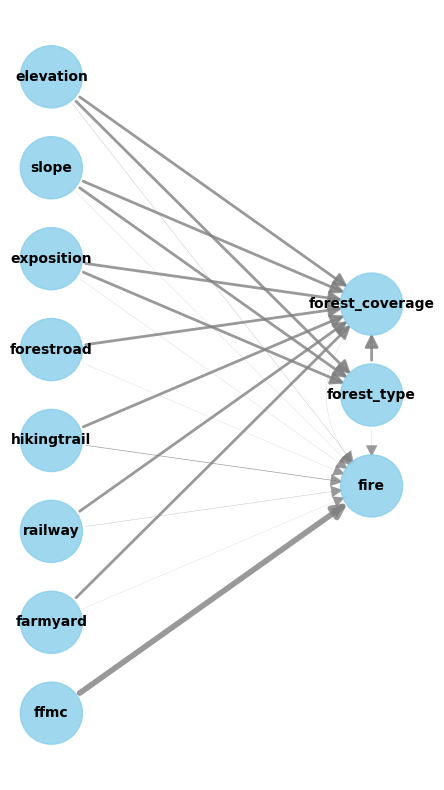

In [124]:
plot(causal_graph, causal_strengths=strength_median)

#### Prediction 

In [206]:
data_obs_prep

,date,exposition,elevation,slope,ffmc,farmyard,forestroad,railway,hikingtrail,population,forest_type,forest_coverage,fire
0,2020-11-11,S,715.732910,24.910730,85.318932,0,0,0,1,0-50 P/km2,low and no vegetation,60<cc<=80,1
1,2020-08-28,E,490.264099,8.630431,89.372231,0,0,0,0,0,low and no vegetation,60<cc<=80,1
2,2020-08-22,W,1770.372925,23.027491,86.986542,0,0,0,0,0-50 P/km2,coniferous non pine,cc>80,1
3,2020-08-20,S,473.768585,13.470551,89.096779,0,1,0,0,100-500 P/km2,low and no vegetation,cc>80,1
4,2020-07-31,NW,1901.101196,52.546978,86.241127,0,0,0,0,0,pine pure,60<cc<=80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,2010-04-28,SE,441.019073,8.551926,88.766060,0,0,0,0,0,coniferous deciduous mixed with pine,60<cc<=80,0
2233,2012-11-10,S,151.142197,0.970928,83.414871,0,0,0,0,0,deciduous pure,cc>80,0
2234,2016-07-26,S,654.048462,21.429167,85.952606,0,1,0,0,0,coniferous non pine,cc>80,0
2235,2006-03-28,W,376.190979,18.626778,71.604172,0,1,0,0,0-50 P/km2,deciduous pure,cc>80,0


In [208]:
scenario = {
    "ffmc": lambda x: 85.3,
    "elevation": lambda x: 715,
    "exposition": lambda x: "S",
    "slope": lambda x: 25,
    "farmyard": lambda x: "0",
    "forestroad": lambda x: "0",
    "railway": lambda x: "0",
    "hikingtrail": lambda x: "1",
    "population": lambda x: "0",
    "forest_type": lambda x: "low and no vegetation",
    "forest_coverage": lambda x: "60<cc<=80"
}

samples = gcm.interventional_samples(causal_model,
                                     scenario,
                                     num_samples_to_draw=1000)

In [209]:
np.mean(samples.fire.astype("int"))


In [219]:


scenario = {
    "ffmc": lambda x: 50,
    "elevation": lambda x: 1000.923645,
    "exposition": lambda x: "SE",
    "slope": lambda x: 15.471358,
    "farmyard": lambda x: "0",
    "forestroad": lambda x: "0",
    "railway": lambda x: "0",
    "hikingtrail": lambda x: "0",
    "population": lambda x: "50-100 P/km2",
    "forest_type": lambda x: "pine pure",
    "forest_coverage": lambda x: "cc>80"
}

samples = gcm.interventional_samples(causal_model,
                                     scenario,
                                     num_samples_to_draw=1000)

print(np.mean(samples.fire.astype("int")))
print(np.std(samples.fire.astype("int")))

0.001
0.03160696125855851
